In [1]:
import sys
#sys.path.append('\\paper_1_supply_chain_visibility')

import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy.stats as st

from calculate_scv import calculate_supply_chain_visibility, create_bias_df, Node, normalize
from degrade_data.noise_data import assign_noise
from degrade_data.bias_data import sample_bias
from degrade_data.missing_data import delete_values_completely_random


import warnings
warnings.filterwarnings("ignore")

In [2]:
df_in = pd.read_csv("C:/Users/IvS/Git/toy_model/data/20221005_GT_TimeSeries_ManufacturingTime2.5_Runtime364.csv")
df = df_in.set_index("Time")
df = df_in.set_index("Time")
df_truemodel = df.groupby(["Time"]).mean().iloc[:, 1:-1]
df_truemodel.iloc[0,0] = 0 #set only value of supplier on 0

# Degrade data based on Scenario

Add 25% bias for the total dataframe

In [102]:
bias_df = create_bias_df(df_truemodel, 0.25, seed=1)

Add noise based on scenario to the dataframe
* Bad actors: 95%
* General actors: 10%

In [104]:
actors = list(df_truemodel.columns)

In [105]:
scenario_manufacturer_2_bad = [0.1, 0.1, 0.95, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
scenario_transit_bad = [0.1, 0.1, 0.1, 0.1, 0.95, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

scenario_supply_vision = [0.1, 0.2, 0.2, 0.3, 0.4, 0.5, 0.5, 0.7, 0.8, 0.8, 0.8]
scenario_demand_vision = [0.8, 0.7, 0.7, 0.5, 0.4, 0.3, 0.3, 0.2, 0.1, 0.1, 0.1]

In [106]:
noise_bias_df = bias_df.copy()

In [107]:
for actor, perc in zip(actors, scenario_manufacturer_2_bad):
    noise_bias_df[actor] = assign_noise(perc, bias_df[[actor]])

Add missing values
* Bad actors: 95%
* General actors: 25%

In [109]:
scenario_manufacturer_2_bad_mv = [0.25, 0.25, 0.95, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
scenario_transit_bad_mv = [0.25, 0.25, 0.25, 0.25, 0.95, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]

scenario_supply_vision_mv = [0.25, 0.35, 0.35, 0.45, 0.55, 0.65, 0.65, 0.85, 0.95, 0.95, 0.95]
scenario_demand_vision_mv = [0.95, 0.85, 0.85, 0.65, 0.55, 0.45, 0.45, 0.35, 0.25, 0.25, 0.25]

In [110]:
modified_df = noise_bias_df.copy()

In [111]:
for actor, perc in zip(actors, scenario_manufacturer_2_bad_mv):
    modified_df[actor] = delete_values_completely_random(perc, noise_bias_df[[actor]])

In [112]:
modified_df

,Supplier,Manufacturer,Manufacturer_2,Export_Port,Transit_Port,Import_Port_Rotterdam,Import_Port_Antwerpen,Wholesales_Distributor,Retailer_Amsterdam,Retailer_Utrecht,Retailer_Venlo
0.0,0.0,554.500000,NaN,7016.400000,603.40,113.95,117.85,77.70,3.066667,0.000000,NaN
1.0,NaN,117.550000,NaN,0.000000,0.00,0.00,0.00,0.00,0.000000,NaN,0.00
2.0,0.0,NaN,NaN,10.700000,0.00,0.00,0.00,NaN,0.000000,0.000000,0.00
3.0,0.0,147.450000,85.808022,NaN,0.00,NaN,0.00,0.00,NaN,0.000000,0.00
4.0,NaN,147.500000,NaN,161.600000,0.00,NaN,0.00,NaN,0.000000,0.000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...
360.0,NaN,676.550000,NaN,21180.700000,1176.10,128.35,133.10,48.30,2.883333,2.883333,NaN
361.0,NaN,689.350000,NaN,NaN,1097.05,NaN,113.10,47.85,NaN,NaN,5.70
362.0,NaN,660.050000,NaN,52380.320078,NaN,162.05,111.10,NaN,3.416667,5.750000,0.00
363.0,0.0,619.350000,NaN,21363.200000,1203.95,143.10,119.35,NaN,NaN,10.816667,6.65


This is a general formula for degrading data for the scenarios as presented in the paper.

In [6]:
def degrade_data(data_set, scenario_perc_noise, scenario_perc_missing, seed):
    random.seed(seed)
    np.random.seed(seed)
    
    #First, Bias
    bias_df = create_bias_df(data_set, 0.25, seed=seed)
    
    #Second, Noise
    actors = list(data_set.columns)
    noise_bias_df = bias_df.copy()
    for actor, perc in zip(actors, scenario_perc_noise):
        noise_bias_df[actor] = assign_noise(perc, bias_df[[actor]])
        
    #Third, Missing Values
    modified_df = noise_bias_df.copy()
    for actor, perc in zip(actors, scenario_perc_missing):
        modified_df[actor] = delete_values_completely_random(perc, noise_bias_df[[actor]])
    
    return modified_df

# Calculate Supply Chain Visibility for Scenarios
With 200 seeds

In [7]:
def calculate_scv_scenarios(data_set, df_degrade_data, names_nodes, levels_nodes, seed=2):
    nodes = []
    for name, level in zip(names_nodes, levels_nodes):
        node = Node(data_set, df_degrade_data, name, level)
        nodes.append(node)
        #print(node.name, "quality", node.quality, "quantity", node.quantity)

    #Determine weights
    inventory_nodes = [node.average_inventory for node in nodes]
    #Normalize to ensure that it sums up to 1
    norm_weights = normalize(inventory_nodes)

    scv_weight_inventory = sum([node.scv*weight for node, weight in zip(nodes, norm_weights)])

    #print("Global supply chain visibility is ", scv_weight_inventory, "%")

    return scv_weight_inventory, nodes


In [1]:
#Define scenarios
scenario_manufacturer_2_bad_noise = [0.1, 0.1, 0.95, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
scenario_transit_bad_noise = [0.1, 0.1, 0.1, 0.1, 0.95, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

scenario_supply_vision_noise = [0.1, 0.2, 0.2, 0.3, 0.4, 0.5, 0.5, 0.7, 0.8, 0.8, 0.8]
scenario_demand_vision_noise = [0.8, 0.7, 0.7, 0.5, 0.4, 0.3, 0.3, 0.2, 0.1, 0.1, 0.1]

scenario_manufacturer_2_bad_mv = [0.25, 0.25, 0.95, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
scenario_transit_bad_mv = [0.25, 0.25, 0.25, 0.25, 0.95, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]

scenario_supply_vision_mv = [0.25, 0.35, 0.35, 0.45, 0.55, 0.65, 0.65, 0.85, 0.95, 0.95, 0.95]
scenario_demand_vision_mv = [0.95, 0.85, 0.85, 0.65, 0.55, 0.45, 0.45, 0.35, 0.25, 0.25, 0.25]

In [9]:
names_supplychain = list(df_truemodel.columns)
levels = [1, 2, 2, 3, 4, 5, 5, 6, 7, 7, 7]


scenarios = [(scenario_manufacturer_2_bad_noise, scenario_manufacturer_2_bad_mv),
            (scenario_transit_bad_noise, scenario_transit_bad_mv),
            (scenario_supply_vision_noise, scenario_supply_vision_mv),
            (scenario_demand_vision_noise, scenario_demand_vision_mv )]
names_scenarios = ["manufacturer_2_bad", "transit_bad", "supply_vision", "demand_vision"]
results_dim = {}

for scen, name in zip(scenarios, names_scenarios):
    results_dim[name] = {}
    
    seed_global_scv = []
    results = defaultdict()
        
    for i in range(1,201):
        degrade_df = degrade_data(df_truemodel, scen[0], 
                                      scen[1], seed = i)
        global_scv, nodes = calculate_scv_scenarios(df_truemodel, degrade_df, names_supplychain, levels, seed=i)
        seed_global_scv.append(global_scv)
        results_seed = {"global_scv": global_scv,
                        "nodes": nodes}
        results[i] = results_seed
        seed_global_scv.append(global_scv)
        
    results["list_scv_per_seed"] = seed_global_scv
    results["mean_global_scv"] = np.mean(seed_global_scv)

    results_dim[name] = results
#         print(seed_global_scv)
    print("Mean Global SCV", np.mean(seed_global_scv))



Mean Global SCV 72.88737814905642
Mean Global SCV 71.87704417639418
Mean Global SCV 58.500732028546594
Mean Global SCV 40.583726071338


# Boxplot

In [13]:
from matplotlib.cbook import boxplot_stats

        mean       iqr       cilo       cihi     whishi     whislo  \
0  72.887378  1.339607  72.808473  73.018791  75.354009  70.454432   
1  71.877044  1.366321  71.702883  71.917395  74.476112  69.349926   
2  58.500732  2.016728  58.405044  58.721670  62.440186  54.609895   
3  40.583726  3.033213  40.562422  41.038637  45.837535  34.748804   

                                              fliers         q1        med  \
0  [70.25445442409267, 70.25445442409267, 68.7258...  72.283260  72.913632   
1  [68.89929083328143, 68.89929083328143, 68.4714...  71.279006  71.810139   
2  [54.44167318878297, 54.44167318878297, 54.2890...  57.607755  58.563357   
3  [33.2143133035649, 33.2143133035649, 33.783090...  39.192610  40.800529   

          q3    min_max     q3_q1  steps_decrease  
0  73.622867   4.899577  1.339607             NaN  
1  72.645327   5.126186  1.366321        1.103493  
2  59.624484   7.830291  2.016728       13.246782  
3  42.225823  11.088731  3.033213       17.762828 

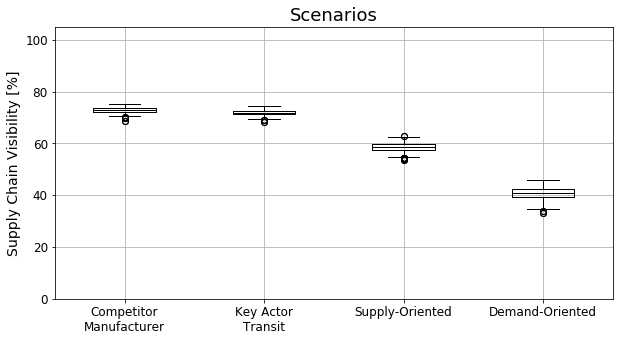

In [36]:
colors=["gray", "darkblue", "deepskyblue", "purple"]
data_sparse_perc = ["Competitor" "\n" "Manufacturer", "Key Actor" "\n" "Transit", "Supply-Oriented", "Demand-Oriented"]
ticks = [1,2,3,4]
plt.figure(figsize=(10,5))
plt.grid()
    
outcome_seeds = [v["list_scv_per_seed"] for k,v in results_dim.items()]
list_mean = [np.mean(v["list_scv_per_seed"]) for k,v in results_dim.items()]
list_std = [np.std(j) for j in outcome_seeds]
    
plt.title("Scenarios", fontsize = 18)
    #plt.boxplot(outcome_seeds, medianprops=dict(color=col))
plt.boxplot(outcome_seeds, medianprops=dict(color="black")) #color = black
stats = pd.DataFrame(boxplot_stats(outcome_seeds))
stats["min_max"] = stats["whishi"] - stats["whislo"]
stats["q3_q1"] = stats["q3"] - stats["q1"]
stats["steps_decrease"] = stats["med"].shift(1) - stats["med"]
print(stats)
#plt.plot(list(range(1, len(median)+1)), median)

    #Adds the scatter
# for i in range(len(outcome_seeds)):
#     y_scatter = outcome_seeds[i]
#     x_scatter = np.random.normal(i + 1, 0.04, len(y_scatter))
#     plt.scatter(x_scatter, y_scatter, color=col, alpha=0.1)
    
plt.ylabel("Supply Chain Visibility [%]", fontsize = 14)
plt.xticks(ticks, data_sparse_perc, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim((0,105))
plt.show()

We see that with demand-oriented scenario, meaning the retailer see more of what's happening close to them and less of the supply side, that supply chain visibility is lower than with supply-oriented scenario (suppliers see what's happening close to them and less on the demand side). This is interesting as more actors are involved in the demand side than on the supply side, meaning in total there are more datapoints in the system. However, this does not contribute that much to the global supply chain visibility, since probably more inventory is based at the supply side. We calculate the weight of each actor in the global supply chain visibility on the average inventory of this actor. This could be the reason why supply chain visibility is low on the demand side -- but this is close to real life.

For the difference between one competitor and the transit port (a key actor in the supply chain), little difference in the effect on supply chain visibility holds. Expected is that less data provided by the key actor would cause propogated lower supply chain visibility, but it looks like this is not the case. This has to do with the way we calculate supply chain visibility.

# Plot Supply Chain Visibility per Actor

In [20]:
#To scenario - node
dict_scenario_nodes = defaultdict()
for scen, seed_dict in results_dim.items():
    dict_nodes = defaultdict(list)
    dict_scenario_nodes[scen] = dict_nodes
        
    for seed, results in seed_dict.items():
        try:
            all_nodes = results["nodes"]
            for i in range(len(all_nodes)):
                dict_nodes[i].append(all_nodes[i])
            #for general keys
        except (TypeError, IndexError):
            continue
                

In [21]:
#To scenario - scv
dim_scen_node_scv = {}
for scen, nodes in dict_scenario_nodes.items():
    node_scv = {}
    for node, all_nodes in nodes.items():
        name = all_nodes[0].name
        node_scv[name] = [max(0, i.scv) for i in all_nodes]
    dim_scen_node_scv[scen] = node_scv

[86.64207589311613, 80.21884380377038, 9.408374711054968, 75.33859643370481, 78.44848279082026, 77.93991884695673, 77.93893505202449, 77.46800863337813, 69.48823716130094, 83.19174509834843, 83.26327579263034]
[86.64207589311613, 80.22025340198793, 80.8114014849267, 75.33600911099211, 9.036172922156723, 77.80853491800588, 78.04003296466573, 77.5033485211168, 69.48316006728463, 83.21202817433519, 83.21861095226808]
[86.64207589311613, 71.1289321193867, 71.74509993283164, 58.18757620822259, 52.05356026813022, 42.41804428704205, 42.59213636139002, 23.544178917372783, 7.928175915837679, 12.422719066247785, 12.936447556886371]
[22.20699630592816, 24.63483011504512, 24.76915147806893, 40.83861653859974, 51.89456700013705, 60.29346772674843, 60.40234543308807, 68.55851605638027, 69.6442159199614, 83.25516262011038, 83.225954390841]


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], <a list of 11 Text xticklabel objects>)

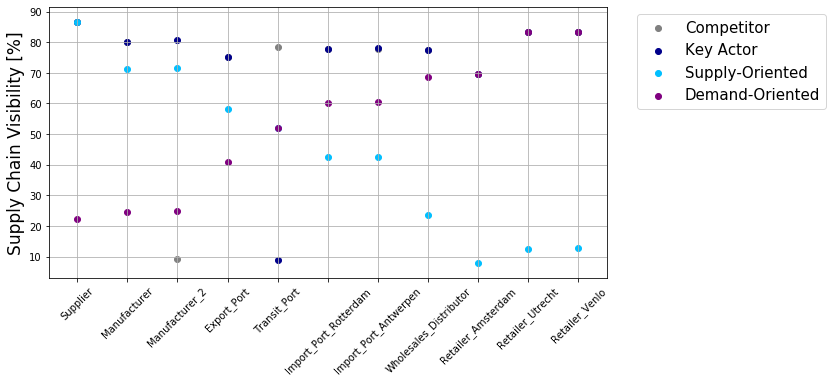

In [22]:
plt.figure(figsize=(10,5))
plt.grid()


colors=["gray", "darkblue", "deepskyblue", "purple"]
scenario_name = ["Competitor", "Key Actor", "Supply-Oriented", "Demand-Oriented"]
for (scen, col, name) in zip(dim_scen_node_scv.keys(), colors, scenario_name):
    x = [node for node in dim_scen_node_scv[scen].keys()]
    y = [np.mean(scv) for node, scv in dim_scen_node_scv[scen].items()]
    print(y)
    plt.scatter(x,y, color=col, label=name)
    #plt.plot(x,y,color=col)
    
    
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize=15)
plt.ylabel("Supply Chain Visibility [%]", fontsize = 17)
plt.xticks(rotation=45)


## Plot supply chain visibility per scenario and per actor

In [23]:
for scen, v in dim_scen_node_scv.items():
    x = [node for node in dim_scen_node_scv[scen].keys()]
    y = [np.mean(scv) for node, scv in dim_scen_node_scv[scen].items()]

In [25]:
outcome_seeds = [v["list_scv_per_seed"] for k,v in results_dim.items()]
mean = [np.mean(v["list_scv_per_seed"]) for k,v in results_dim.items()]
std = [np.std(j) for j in outcome_seeds]

In [89]:
outcome_seeds_scen = [node[n] for scen, node in dim_scen_node_scv.items()]

[86.64207589311613, 86.64207589311613, 86.64207589311613, 22.20699630592816]
Supplier [1, 1, 1, 1]
[80.21884380377038, 80.22025340198793, 71.1289321193867, 24.63483011504512]
Manufacturer [63.836924323945254, 62.994866986542775, 87.8615484589659, 231.6448100891897]
[9.408374711054968, 80.8114014849267, 71.74509993283164, 24.76915147806893]
Manufacturer_2 [349.9438524369971, 65.61925521831711, 89.71839535541051, 250.97029945542033]
[75.33859643370481, 75.33600911099211, 58.18757620822259, 40.83861653859974]
Export_Port [105.09965098756027, 106.77389110738886, 177.13641624194736, 230.8387439583825]
[78.44848279082026, 9.036172922156723, 52.05356026813022, 51.89456700013705]
Transit_Port [77.47911716851661, 402.3044238672387, 160.99986719143544, 161.16735402645617]
[77.93991884695673, 77.80853491800588, 42.41804428704205, 60.29346772674843]
Import_Port_Rotterdam [87.259804089706, 75.0131854360518, 202.9817275078969, 138.4025681189982]
[77.93893505202449, 78.04003296466573, 42.592136361390

(array([  0.,  20.,  40.,  60.,  80., 100.]),
 <a list of 6 Text yticklabel objects>)

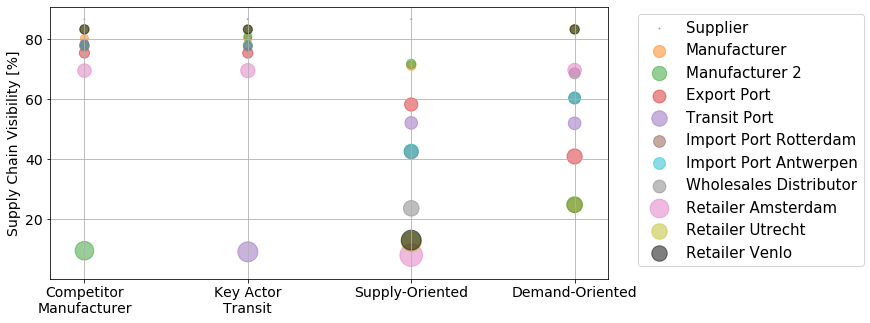

In [32]:
plt.figure(figsize=(10,5))
plt.grid()

#colors=["gray", "darkblue", "deepskyblue", "purple"]

names_scenarios = ["manufacturer_2_bad", "transit_bad", "supply_vision", "demand_vision"]
node_names = [node[0] for node in dim_scen_node_scv[names_scenarios[0]].items()]

x =  ["Competitor" "\n" "Manufacturer", "Key Actor" "\n" "Transit", "Supply-Oriented", "Demand-Oriented"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:cyan" , "tab:gray", "tab:pink", "tab:olive", "black"]

for (n, col) in zip(node_names, colors):
    y = [np.mean(node[n])for scen, node in dim_scen_node_scv.items()]
    print(y)
    
    outcome_seeds_scen = [node[n] for scen, node in dim_scen_node_scv.items()]
    mean = [np.mean(i) for i in outcome_seeds_scen]
    std = [np.std(i)*100 for i in outcome_seeds_scen]
    
    #Add confidence interval
    conf_seed = [st.t.interval(alpha=0.95, df=len(j)-1, loc=np.mean(j), scale=st.sem(j)) for j in outcome_seeds_scen]
    min_interval = [interval[0]for interval in conf_seed]
    max_interval = [min(100, interval[1]) for interval in conf_seed]
        
    min_error = [abs(i-j) for i,j in zip(min_interval, mean)]
    max_error = [max(1, abs(i-j)*600) for i,j in zip(max_interval, mean)]
        
    if name == "Retailer_Amsterdam" or name == "Wholesales_Distributor" or name == "Transit_Port" or name == "Import_Port_Rotterdam" or name == "Import_Port_Antwerpen" or name == "Export_Port":
        max_error = [min(100, abs(i-j)*600) for i,j in zip(max_interval, mean)]
    
    
    total_error = [min_error, max_error]
    
    plt.scatter(x,y, label=n.title().replace("_"," "), s=max_error, color = col, edgecolors=col, alpha=0.5)
    print(n,max_error)

    
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize=15)
plt.ylabel("Supply Chain Visibility [%]", fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


----------------------------------------------------------

# Sensitivity - changing the values in the scenarios
* Missing values for bad actors = 75%
* We go only 5% up or down on supply or demand-oriented scenario

In [151]:
scenario_manufacturer_2_bad_noise = [0.1, 0.1, 0.95, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
scenario_transit_bad_noise = [0.1, 0.1, 0.1, 0.1, 0.95, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

scenario_supply_vision_noise = [0.1, 0.2, 0.2, 0.3, 0.4, 0.5, 0.5, 0.7, 0.8, 0.8, 0.8]
scenario_demand_vision_noise = [0.8, 0.7, 0.7, 0.5, 0.4, 0.3, 0.3, 0.2, 0.1, 0.1, 0.1]

scenario_manufacturer_2_bad_mv = [0.25, 0.25, 0.75, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
scenario_transit_bad_mv = [0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]

scenario_supply_vision_mv = [0.25, 0.30, 0.30, 0.35, 0.40, 0.45, 0.45, 0.50, 0.55, 0.55, 0.55]
scenario_demand_vision_mv = [0.55, 0.50, 0.50, 0.45, 0.40, 0.40, 0.35, 0.30, 0.25, 0.25, 0.25]

In [152]:
names_supplychain = list(df_truemodel.columns)
levels = [1, 2, 2, 3, 4, 5, 5, 6, 7, 7, 7]


scenarios = [(scenario_manufacturer_2_bad_noise, scenario_manufacturer_2_bad_mv),
            (scenario_transit_bad_noise, scenario_transit_bad_mv),
            (scenario_supply_vision_noise, scenario_supply_vision_mv),
            (scenario_demand_vision_noise, scenario_demand_vision_mv )]
names_scenarios = ["manufacturer_2_bad", "transit_bad", "supply_vision", "demand_vision"]
results_dim = {}

for scen, name in zip(scenarios, names_scenarios):
    results_dim[name] = {}
    
    seed_global_scv = []
    results = defaultdict()
        
    for i in range(1,201):
        degrade_df = degrade_data(df_truemodel, scen[0], 
                                      scen[1], seed = i)
        global_scv, nodes = calculate_scv_scenarios(df_truemodel, degrade_df, names_supplychain, levels, seed=i)
        seed_global_scv.append(global_scv)
        results_seed = {"global_scv": global_scv,
                        "nodes": nodes}
        results[i] = results_seed
        seed_global_scv.append(global_scv)
        
    results["list_scv_per_seed"] = seed_global_scv
    results["mean_global_scv"] = np.mean(seed_global_scv)

    results_dim[name] = results
#         print(seed_global_scv)
    print("Mean Global SCV", np.mean(seed_global_scv))


Mean Global SCV 73.52128121607647
Mean Global SCV 72.63824225989214
Mean Global SCV 63.64893652380906
Mean Global SCV 51.48260657866171


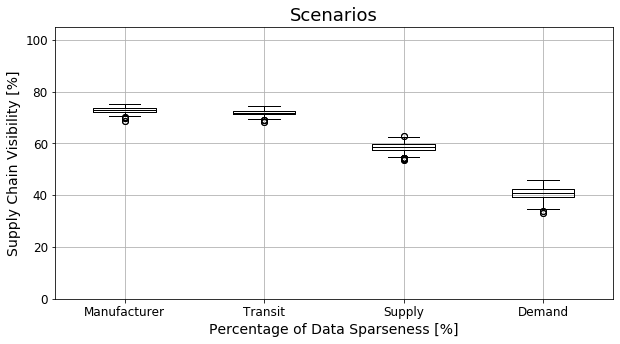

In [12]:
colors=["gray", "darkblue", "deepskyblue", "purple"]
data_sparse_perc = ["Manufacturer", "Transit", "Supply", "Demand"]
ticks = [1,2,3,4]
#     mean = [np.mean(v["list_scv_per_seed"]) for k,v in sparse_dict.items()]
#     print("mean", dim.title(), mean)
    
#     median = [np.median(v["list_scv_per_seed"]) for k,v in sparse_dict.items()]
#     print("median", dim.title(), median)
    
plt.figure(figsize=(10,5))
plt.grid()
    
outcome_seeds = [v["list_scv_per_seed"] for k,v in results_dim.items()]

list_mean = [np.mean(v["list_scv_per_seed"]) for k,v in results_dim.items()]
list_std = [np.std(j) for j in outcome_seeds]
    
plt.title("Scenarios", fontsize = 18)
    #plt.boxplot(outcome_seeds, medianprops=dict(color=col))
plt.boxplot(outcome_seeds, medianprops=dict(color="black")) #color = black
#     stats = pd.DataFrame(boxplot_stats(outcome_seeds))
#     stats["min_max"] = stats["whishi"] - stats["whislo"]
#     stats["steps_decrease"] = stats["med"].shift(1) - stats["med"]
#     print(dim.title(), stats)
    #plt.plot(list(range(1, len(median)+1)), median)
    
    #Adds the scatter
# for i in range(len(outcome_seeds)):
#     y_scatter = outcome_seeds[i]
#     x_scatter = np.random.normal(i + 1, 0.04, len(y_scatter))
#     plt.scatter(x_scatter, y_scatter, color=col, alpha=0.1)
    
plt.xlabel("Percentage of Data Sparseness [%]", fontsize = 14)
plt.ylabel("Supply Chain Visibility [%]", fontsize = 14)
plt.xticks(ticks, data_sparse_perc, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim((0,105))
plt.show()